In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
import warnings

warnings.filterwarnings("ignore")


# Airline Passenger Satisfaction Analysis
This dataset contains an airline passenger satisfaction survey. What factors are highly correlated to a satisfied (or dissatisfied) passenger? Can you predict passenger satisfaction? 


In [2]:
train_df = pd.read_csv("test.csv", index_col=0)
train_df.drop("id", axis=1, inplace=True)
test_df = pd.read_csv("train.csv", index_col=0)
test_df.drop("id", axis=1, inplace=True)


In [54]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


<a id = "2"></a><br>
# Variable Description
1. id : Unique id number to each passenger.
2. Gender: Gender of the passengers (Female, Male)
3. Customer Type: The customer type (Loyal customer, disloyal customer)
4. Age: The actual age of the passengers
5. Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
6. Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
7. Flight distance: The flight distance of this journey
8. Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
9. Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
10. Ease of Online booking: Satisfaction level of online booking
11. Gate location: Satisfaction level of Gate location
12. Food and drink: Satisfaction level of Food and drink
13. Online boarding: Satisfaction level of online boarding
14. Seat comfort: Satisfaction level of Seat comfort
15. Inflight entertainment: Satisfaction level of inflight entertainment
16. On-board service: Satisfaction level of On-board service
17. Leg room service: Satisfaction level of Leg room service
18. Baggage handling: Satisfaction level of baggage handling
19. Check-in service: Satisfaction level of Check-in service
20. Inflight service: Satisfaction level of inflight service
21. Cleanliness: Satisfaction level of Cleanliness
22. Departure Delay in Minutes: Minutes delayed when departure
23. Arrival Delay in Minutes: Minutes delayed when Arrival
24. Satisfaction: Airline satisfaction level(satisfied, neutral or dissatisfaction)

* int64(18): id, Age,Flight Distance, Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness and Departure Delay in Minutes.
* object(5): Gender, Customer Type, Type of Travel, Class and satisfaction.
* float64(1): Arrival Delay in Minutes.

<a id = "7"></a><br>
# Outlier Detection


In [3]:
def detect_outliers(df,features):
    outlier_indices=[]
    
    for c in features:
        # 1st quartile
        Q1=np.percentile(df[c],25)
        
        # 3rd quartile
        Q3=np.percentile(df[c],75)
        
        # IQR
        IQR= Q3-Q1
        
        # Outlier Step
        outlier_step= IQR * 1.5
        
        # Detect outlier and their indeces 
        outlier_list_col = df[(df[c]< Q1 - outlier_step)|( df[c] > Q3 + outlier_step)].index
        
        # Store indices 
        outlier_indices.extend(outlier_list_col)
    
    outliers_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i , v in outliers_indices.items() if v>2 )
    return multiple_outliers

In [4]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [6]:
train_df.loc[
    detect_outliers(
        train_df,
        [
            "Age",
            "Flight Distance",
            "Inflight wifi service",
            "Departure/Arrival time convenient",
            "Ease of Online booking",
            "Gate location",
            "Food and drink",
            "Online boarding",
            "Seat comfort",
            "Inflight entertainment",
            "On-board service",
            "Leg room service",
            "Baggage handling", 'Age', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes',
       'Arrival_Delay_in_Minutes',
        "Checkin service",
        "Inflight service",
        "Cleanliness",
        "Departure Delay in Minutes",
        "Arrival Delay in Minutes",
        ],
    )
]


KeyError: 'Flight_Distance'

In [ ]:
# Droping outliers
train_df = train_df.drop(detect_outliers(train_df,[ "Age",
            "Flight Distance",
            "Inflight wifi service",
            "Departure/Arrival time convenient",
            "Ease of Online booking",
            "Gate location",
            "Food and drink",
            "Online boarding",
            "Seat comfort",
            "Inflight entertainment",
            "On-board service",
            "Leg room service",
            "Baggage handling",
            "Checkin service",
            "Inflight service",
            "Cleanliness",
            "Departure Delay in Minutes",
            "Arrival Delay in Minutes",]),axis = 0).reset_index(drop = True)

In [ ]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [7]:
plt.figure(figsize=(10, 10))
list1 = [
    "Age",
    "Inflight_wifi_service",
    "Departure/Arrival_time_convenient",
    "Ease_of_Online_booking",
    "Gate_location",
    "Food_and_drink",
    "Online_boarding",
    "Seat_comfort",
    "Inflight_entertainment",
    "On-board_service",
    "Leg_room_service",
    "Baggage_handling",
    "Checkin_service",
    "Inflight_service",
    "Cleanliness",
    "satisfaction",
]
sns.heatmap(train_df[list1].corr(), annot=True, fmt=".2f")
plt.show()


KeyError: "['Seat_comfort', 'Ease_of_Online_booking', 'Checkin_service', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'On-board_service', 'Online_boarding', 'Baggage_handling', 'Departure/Arrival_time_convenient', 'Leg_room_service', 'Food_and_drink', 'Inflight_service'] not in index"

<Figure size 720x720 with 0 Axes>

<a id = "13"></a><br>
## Gender-->Satisfaction

In [8]:
g = sns.catplot(x="Gender", y="satisfaction", data=train_df, kind="bar", size=6)
g.set_ylabels("Satisfaction Probability")
plt.show()


TypeError: Neither the `x` nor `y` variable appears to be numeric.

* Females and males are satisfaction probability almost equal. Male %44, Female %43 satisfaction.


<a id = "14"></a><br>
## Age-->Satisfaction

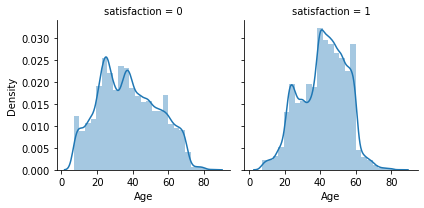

In [ ]:
g= sns.FacetGrid(train_df,col="satisfaction")
g.map(sns.distplot,"Age",bins=25)
plt.show()
# 0=neutral or dissatisfied, 1=satisfied 

* 0-20 years old is  generally neutral or dissatisfied with the flight.
* 30-60 years old is generally satisfied with the flight.
* 65-80 years old passengers is neutral or dissatisfied.

<a id = "15"></a><br>
## Customer Type-->Satisfaction

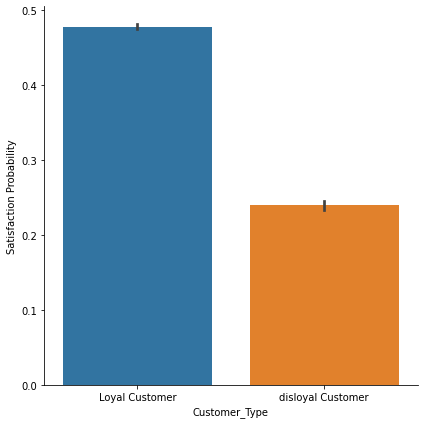

In [ ]:
g=sns.factorplot(x="Customer_Type",y="satisfaction",data=train_df,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.show()

* Disloyal customer is generally neutral or dissatisfied with the flight.

<a id = "16"></a><br>
## Type of Travel-->Satisfaction

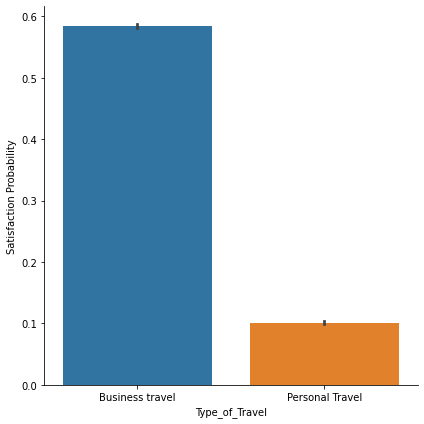

In [ ]:
g=sns.factorplot(x="Type_of_Travel",y="satisfaction",data=train_df,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.show()

* Business travel is generally satisfied with the flight but personal travel is generally neutral or dissatisfied with the flight.
* Personal travel is %90 neutral or dissatisfied with the flight. This statistic is interesting.

<a id = "17"></a><br>
## Class-->Satisfaction

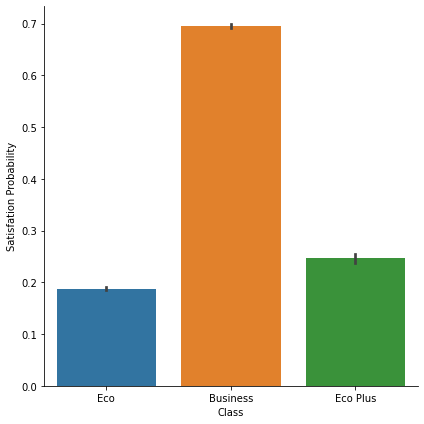

In [ ]:
g = sns.factorplot(x="Class", y="satisfaction", data=train_df, kind="bar", size=6)
g.set_ylabels("Satisfation Probability")
plt.show()


* Business class is also happy here. But eco and eco plus  neutral or dissatisfied with the flight. 

<a id = "22"></a><br>
## Gender-->Age-->Satisfaction

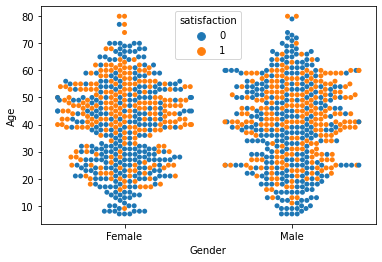

In [ ]:
sns.swarmplot(x="Gender", y="Age",hue="satisfaction", data=train_df.head(1000))
plt.show()
# 0=neutral or dissatisfied, 1=satisfied  

In [ ]:
#Model Building

In [9]:
#Encoding the satisfaction manually to 0 for a neutral or dissatisfied customer and 1 for a satisfied customer.
train_df["satisfaction"] = train_df["satisfaction"].map(
    {"satisfied": 0, "neutral or dissatisfied": 1}
)


In [10]:
#Creating the training dataset
y_train = train_df["satisfaction"]
X_train = train_df.drop("satisfaction", axis=1)

In [11]:
#Creating the test datset
test_df["satisfaction"] = test_df["satisfaction"].map(
    {"satisfied": 0, "neutral or dissatisfied": 1}
)

y_test = train_df["satisfaction"]
X_test = train_df.drop("satisfaction", axis=1)

In [ ]:
train_df.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [ ]:
train_df.select_dtypes(include=['object']).columns.tolist()

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

<a id = "29"></a><br>
# Modeling
* Algorithms that we will use when creating our model;
* Logistic Regression
* Random Forest Classifer
* Decision Tree Classifer
* KNeighbors Classifer

<a id = "32"></a><br>
## Hyperparameter Tuning

* Decision Tree
* Random Forest
* KNN
* Logistic Regression

In [12]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
X_train.columns

Index(['Age', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes',
       'Customer_Type_Loyal Customer', 'Customer_Type_disloyal Customer',
       'Type_of_Travel_Business travel', 'Type_of_Travel_Personal Travel',
       'Class_Business', 'Class_Eco', 'Class_Eco Plus', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

In [13]:
# Using a sklearn pipeline
nomimal_variables = ["Gender", "Type of Travel", "Class", "Customer Type"]
nominal_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("nom_encode", nominal_encoder, nomimal_variables),
    ]
)
model_list = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
]
for model in model_list:
    model_names = ["Decision Tree","Random Forest","Logitic Regression","KNN"]
    clf = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("model", model),
        ]
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    for i in model_names:
        print(f"{i}:")
        print(classification_report(y_pred, y_test))


Decision Tree:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     10106
           1       0.85      0.78      0.81     15870

    accuracy                           0.78     25976
   macro avg       0.77      0.78      0.77     25976
weighted avg       0.79      0.78      0.78     25976

Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     10106
           1       0.85      0.78      0.81     15870

    accuracy                           0.78     25976
   macro avg       0.77      0.78      0.77     25976
weighted avg       0.79      0.78      0.78     25976

Logitic Regression:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     10106
           1       0.85      0.78      0.81     15870

    accuracy                           0.78     25976
   macro avg       0.77      0.78      0.77     25976
weighted avg       0.79 

In [15]:
random_state = 42
classifier = [
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    LogisticRegression(random_state=random_state),
    KNeighborsClassifier(),
]
dt_param_grid = {"min_samples_split": range(10, 500, 20), "max_depth": range(1, 20, 2)}
rf_param_grid = {
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion": ["gini"],
}

logreg_param_grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2"]}
knn_param_grid = {
    "n_neighbors": np.linspace(1, 19, 10, dtype=int).tolist(),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}
classifier_param = [dt_param_grid, rf_param_grid, logreg_param_grid, knn_param_grid]


In [16]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(
        classifier[i],
        param_grid=classifier_param[i],
        cv=StratifiedKFold(n_splits=10),
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
    )
    clf.fit(X_train, y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])


Fitting 10 folds for each of 250 candidates, totalling 2500 fits


ValueError: 
All the 2500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/varun/environments/env3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/varun/environments/env3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/home/varun/environments/env3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 172, in fit
    X, y = self._validate_data(
  File "/home/varun/environments/env3/lib/python3.8/site-packages/sklearn/base.py", line 591, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/home/varun/environments/env3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/home/varun/environments/env3/lib/python3.8/site-packages/pandas/core/generic.py", line 1899, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'Female'


In [ ]:
cv_results = pd.DataFrame({"Cross Validation Means":[0.9426983403065574,0.9574115458084643,0.8198176386217473,0.784126066638906], "ML Models":["DecisionTreeClassifier","RandomForestClassifier",
             "LogisticRegression",
             "KNeighborsClassifier"]})

g = sns.barplot("Cross Validation Means", "ML Models", data = cv_results)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

TypeError: barplot() got multiple values for argument 'data'

* DecisonTreeClassifier accuracy score: 94.2%
* RandomForestClassifier accuracy score: 95.7%
* LogisticRegression : 81.9%
* KNeighborsClassifier: 78.4%

<a id = "33"></a><br>
## Ensemble Modeling
* We will combine 2 algorithms with the best value. These will be random forest classifer and decision tree classifer.
*soft, predicts the class label based on the argmax of the sums of the predicted probabilities, 

In [ ]:
#soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, 

(25976,)

In [14]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ensemble_estimators = [("Decision Tree Classifier", dt), ("Random Forest", rf)]
best_model = VotingClassifier(estimators=ensemble_estimators, voting="soft")
clf = best_model.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_test_prob = clf.predict_proba(X_test)



ValueError: could not convert string to float: 'Female'

* Our model estimates 95.4% correctly. Our model works well.